# Mini-Project (ML for Time Series) - MVA 2021/2022
### Tanguy Magne, Loïc Magne

In [1]:
import numpy as np
import pygsp
import ruptures as rpt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from ruptures.metrics import *
from tqdm import tqdm
from scipy.stats import gamma

SEED = 8976813
np.random.seed(SEED)

In [2]:
def metrics(true_bkps, bkps, verbose=True):
    p, r = rpt.metrics.precision_recall(true_bkps, bkps)
    hausdorff = rpt.metrics.hausdorff(true_bkps, bkps)
    randindex = rpt.metrics.randindex(true_bkps, bkps)
    hamming = rpt.metrics.hamming(true_bkps, bkps)
    if verbose:
        print(f"""
            Hausdorff: {hausdorff:.2f}, 
            Precision: {p:.2f}, 
            Recall: {r:.2f}, 
            Randindex: {randindex:.2f}, 
            Hamming: {hamming:.2f}
        """)
    return p, r, hausdorff, randindex

# Dataset

4 changes points


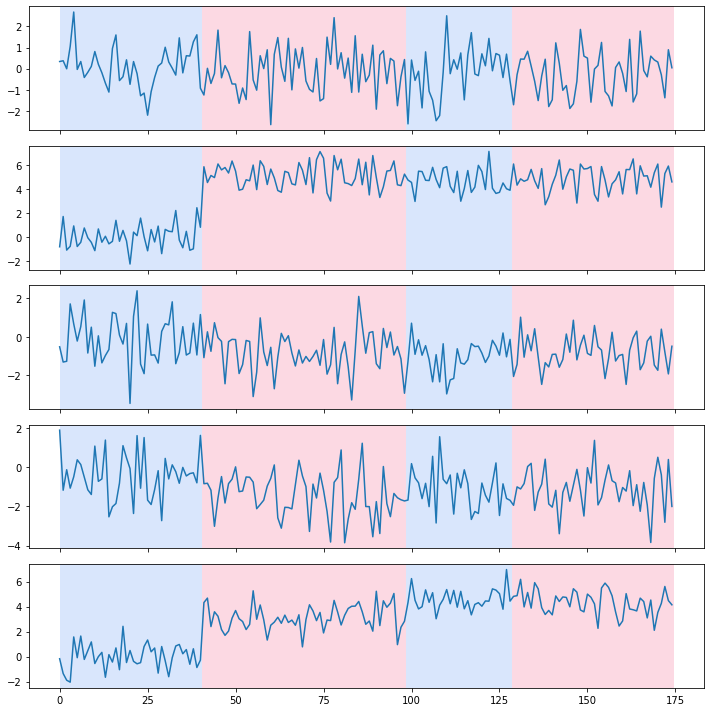

In [3]:
def generate_barabasi_albert(
        n_nodes,
        m_barabasi=4,
        mean_exponential=20,
        random_freq=20
    ):
    # Generate Graph Structure
    G = pygsp.graphs.BarabasiAlbert(N=n_nodes, m0=m_barabasi, m=m_barabasi, seed=SEED)
    G.set_coordinates()
    G.compute_fourier_basis()

    spectral_profile=lambda x: 2*gamma.pdf(x,a=20.,loc=5.)+1.0
    H = pygsp.filters.Filter(G, lambda x: spectral_profile(x))
    PSD = (spectral_profile(G.e))**2

    # Generate Signals
    n_bkps = 4
    bkps = []
    mus = []
    signals = []
    
    acc_bkp = 0
    acc_mean = np.concatenate((np.random.uniform(-5.0,5.0,size=random_freq),np.zeros(n_nodes-random_freq)))
    acc_mean = G.igft(acc_mean).reshape(-1, 1)
    # Make a list of changing points after each breakpoints
    changing_nodes = []
    changing_nodes.append(tuple([[]])) # In the first part, no mean are changed
    max_d = np.argmax(G.d)
    max_d_neighbors = np.where(G.W.todense()[max_d] != 0)[1]
    changing_nodes.append(np.concatenate([max_d_neighbors, [max_d]])) # After the first break, node with maximum degree and neighbord change
    changing_nodes.append(np.argpartition(G.d, -5)[-5:]) # After the second break, 5 nodes with highest degree change
    changing_nodes.append(np.random.choice(range(n_nodes), size=random_freq, replace=False)) # After last break, 20 random nodes are changes

    for i in range(n_bkps):
        # Generate segment
        segment_length = int(np.random.exponential(scale=mean_exponential)+30)
        acc_bkp += segment_length
        acc_mean[changing_nodes[i]] = np.random.uniform(-5.0,5.0,size=(len(changing_nodes[i]),1)) # Changing mean of corresponding nodes
        signal = np.random.normal(size=(n_nodes,segment_length))
        signal = H.filter(signal) + acc_mean

        # Record bkp position, mean and signal
        bkps.append(acc_bkp)
        mus.append(np.copy(acc_mean))
        signals.append(signal)

    signal = np.concatenate(signals, 1)
    return G, PSD, bkps, mus, signal

# Params
n_nodes = 500   
G, PSD, true_bkps, mus, signal = generate_barabasi_albert(n_nodes)
print(f'{len(true_bkps)} changes points')
rpt.display(signal[:5].T, true_bkps)
plt.show()

4 changes points


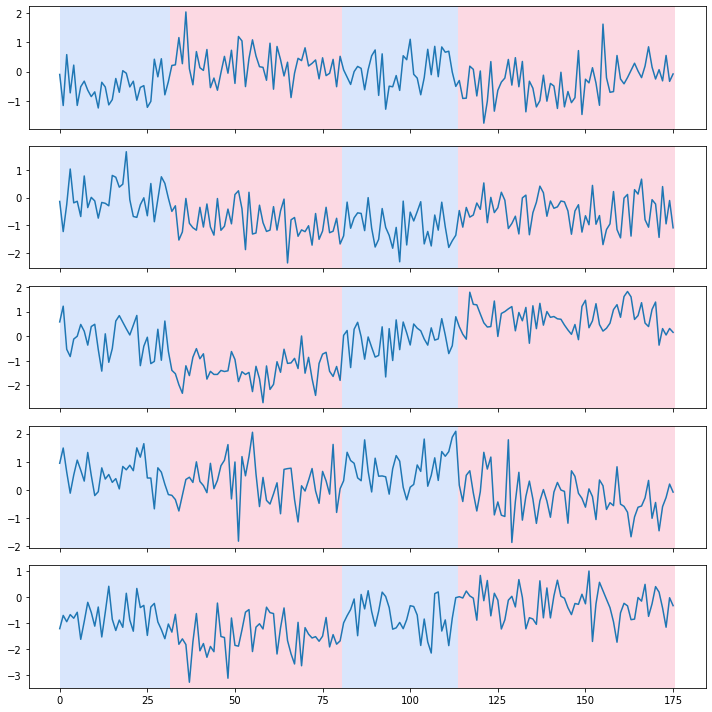

In [4]:
def generate_erdos_renyi(
        n_nodes,
        p=0.3,
        mean_exponential=20,
        mean_change_points=3,
        random_freq=20
    ):
    # Generate Graph Structure
    G = pygsp.graphs.ErdosRenyi(N=n_nodes, p=p, seed=SEED)
    G.set_coordinates()
    G.compute_fourier_basis()

    spectral_profile = lambda x: np.sqrt(15)/(np.log(x+10)+1)
    H = pygsp.filters.Filter(G, lambda x: spectral_profile(x))
    PSD = (spectral_profile(G.e))**2

    # Generate Signals
    n_bkps = np.random.poisson(lam=mean_change_points) + 2
    bkps = []
    mus = []
    signals = []
    
    acc_bkp = 0
    acc_mean = np.zeros((n_nodes,1))
    for bkpt in range(n_bkps):
        # Get new segment mean
        subset_freq = np.random.choice(range(n_nodes), size=random_freq, replace=False)
        if bkpt == 0:
            pass
            # subset_freq = np.arange(random_freq)
        acc_mean[subset_freq] = np.random.uniform(-5.0,5.0,size=(random_freq,1))

        # Generate segment
        segment_length = int(np.random.exponential(scale=mean_exponential)+30)
        acc_bkp += segment_length
        signal = np.random.normal(size=(n_nodes,segment_length)) # Ici on devrait avoir uniform et pas normal
        signal = H.filter(signal) + G.igft(acc_mean)
        # Record bkp position, mean and signal
        bkps.append(acc_bkp)
        mus.append(np.copy(acc_mean))
        signals.append(signal)
    signal = np.concatenate(signals, 1)
    return G, PSD, bkps, mus, signal

# Params
n_nodes = 500
G, PSD, true_bkps, mus, signal = generate_erdos_renyi(n_nodes)
print(f'{len(true_bkps)} changes points')
rpt.display(signal[:5].T, true_bkps)
plt.show()

# PSD Estimation

In [5]:
def gaussian_kernel(x, m, tau, sig_2):
    return np.exp( -np.square(x - m * tau) / sig_2)

def estimate_PSD_cov(signal, G):
    """This functions allows to estimate the PSD of the graphs signals using covariance estimation.

    Args:
        signal: array, shape (n_nodes, T) the stream of graph signals.
        G: pygsp.graphs,  the graph

    Returns:
        PSD : array, shape (n_nodes) : the PSD of the graphs signals 

    """

    cov = np.cov(signal)
    PSD = np.diagonal(np.conj(G.U).T @ cov @ G.U)
    return PSD


def estimate_PSD_perraudin(signal, G, M=100, filtering_method='chebyshev', exact_window_norm=False, interp_degree=15 ):
    """This functions allows to estimate the PSD of the graphs signals using perraudin method.

    Args:
        signal: array, shape (n_nodes, T) the stream of graph signals.
        G: pygsp.graphs,  the graph
        M : int, number of filters to use
        filtering_method : string, method to use for filtering graphs, either "exact" or "chebyshev"
        window_norm : bool, use exact computation of the window norm
        interp_degree: int, polynomial degree for the interpolation 

    Returns:
        PSD : array, shape (n_nodes) : the PSD of the graphs signals 

    """
    np.random.seed(SEED)
    tau = (M+1) * G.lmax / np.square(M)
    sig_2 = tau
    psd = []
    
    if not exact_window_norm:
        noise = np.random.normal(size=(signal.shape[0], 10))

    for m in range(M):
        filter = lambda x : gaussian_kernel(x, m, tau, sig_2)
        G_filter = pygsp.filters.Filter(G, filter)
        
        if exact_window_norm:
            window_norm = np.sum(np.square(filter(G.e))) + 1e-16
        else:
            filterned_noise = G_filter.filter(noise, method=filtering_method)
            window_norm = np.mean(np.sum(np.square(filterned_noise), axis=0))


        filtered_signal = G_filter.filter(signal, method=filtering_method)
        filtered_signal_norm = np.mean(np.sum(np.square(filtered_signal), axis=0))
        
        psd.append(filtered_signal_norm / window_norm)

    xs = tau * np.arange(M)

    coeff=np.polyfit(xs,np.array(psd),deg=interp_degree)
    p = np.poly1d(coeff)

    PSD=p(G.e)
    return PSD
    

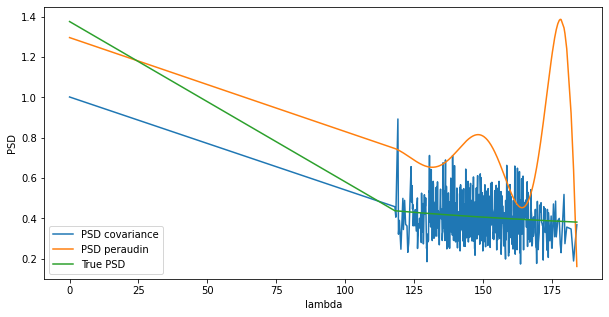

In [6]:
# Compare True PSD and approximation
w = 30
psd_covariance = estimate_PSD_cov(signal[:,:w], G)
psd_perraudin = estimate_PSD_perraudin(signal[:,:w], G)

fig = plt.figure(figsize=(10, 5)) 
plt.plot(G.e, psd_covariance, label="PSD covariance")
plt.plot(G.e, psd_perraudin, label="PSD peraudin")
plt.plot(G.e, PSD, label="True PSD")
plt.xlabel("lambda")
plt.ylabel("PSD")
plt.legend()
plt.show()

# LGS

In [7]:
class CostFunctionLGS(rpt.base.BaseCost):
    model = "lgs"
    min_size = 2
    def __init__(self, psd, lbd):
        self.lbd = lbd
        self.signal = None
        self.psd = psd
        
    def fit(self, signal):
        self.signal = signal
        return self
        
    def error(self, start, end):
        y_tilda_bar = np.mean(self.signal[start:end],axis=0)
        temp = np.abs(y_tilda_bar) - 0.5*self.lbd*self.psd
        mu_tilda_bar = np.sign(y_tilda_bar) * np.maximum(temp,0)
        
        sub_sig = np.square(self.signal[start:end] - mu_tilda_bar) / self.psd
        sub_sig += self.lbd * np.abs(mu_tilda_bar)
        
        return np.sum(sub_sig)

def LGS(G, signal, PSD, d_max=75, lbd=1., verbose=True):
    c1, c2 = 500., 100.
    T = signal.shape[1]
    GFT = signal @ G.U
    PSD = PSD
    cost = CostFunctionLGS(PSD, lbd).fit(GFT)
    algo = rpt.Dynp(custom_cost=cost).fit(GFT)
    best_cost = float('inf')
    best_bkps = None
    loop = tqdm(range(1,d_max+1)) if verbose else range(1,d_max+1)
    for d in loop:
        bkps = algo.predict(n_bkps=d)
        curr_cost = cost.sum_of_costs(bkps) + d * (c1 + c2 * np.log(T/d))
        if curr_cost < best_cost:
            best_cost = curr_cost
            best_bkps = bkps
    return best_bkps

100%|██████████| 34/34 [00:00<00:00, 143.00it/s]


4 changes points

            Hausdorff: 3.00, 
            Precision: 1.00, 
            Recall: 1.00, 
            Randindex: 0.97, 
            Hamming: 0.03
        


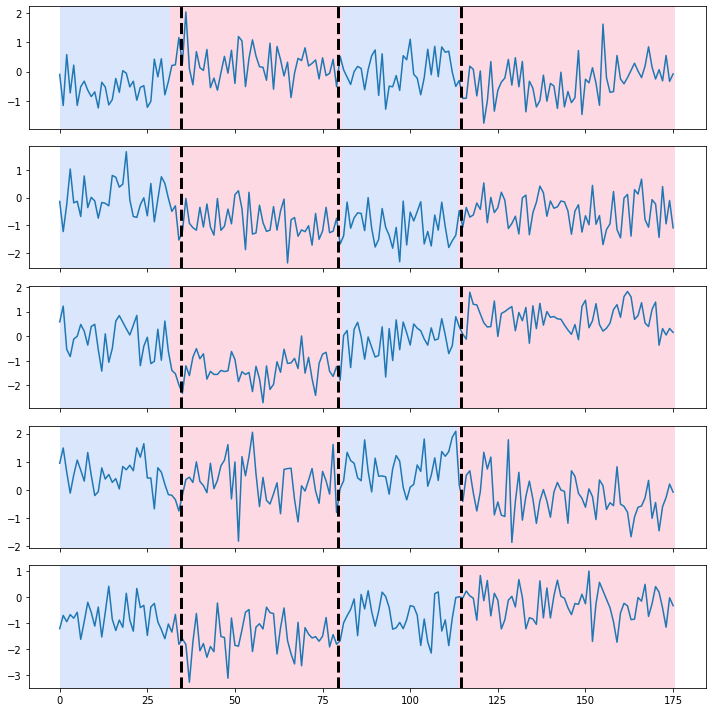

In [8]:
# Results using True PSD
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = LGS(G, signal.T, PSD, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 34/34 [00:00<00:00, 142.33it/s]


4 changes points

            Hausdorff: 3.00, 
            Precision: 1.00, 
            Recall: 1.00, 
            Randindex: 0.97, 
            Hamming: 0.03
        


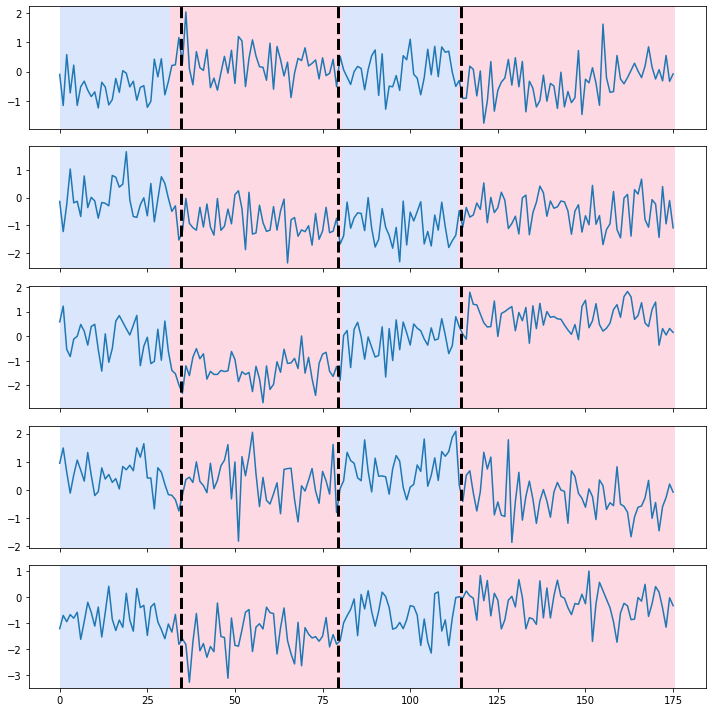

In [9]:
# Results using PSD estimation through covariance estimation
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = LGS(G, signal.T, psd_covariance, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 34/34 [00:00<00:00, 150.21it/s]


3 changes points

            Hausdorff: 34.00, 
            Precision: 1.00, 
            Recall: 0.67, 
            Randindex: 0.88, 
            Hamming: 0.12
        


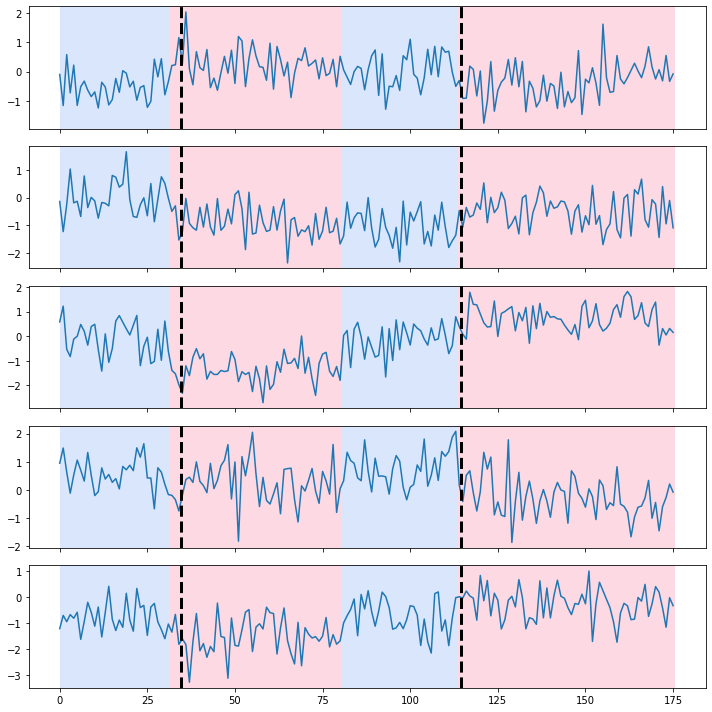

In [10]:
# Results using PSD estimation with perraudin methods
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = LGS(G, signal.T, psd_perraudin, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

# VSGS

In [11]:
def lassoVSGS(signal, PSD, lbd):
    """
    Solves the lasso problem from Algorithm2 VSGS
    Solution is computed via a closed form
    """
    emp_mean = np.mean(signal, axis=0)
    temp = np.abs(emp_mean) - 0.5*lbd*PSD
    mu = np.sign(emp_mean) * np.maximum(temp,0)
    return mu

class CostFunctionVSGS(rpt.base.BaseCost):
    model = "vsgs"
    min_size = 2
    def __init__(self, psd, filter_mask):
        self.signal = None
        self.filter_mask = filter_mask
        self.psd = psd
        
    def fit(self, signal):
        self.signal = signal
        return self
        
    def error(self, start, end):
        emp_mean = np.mean(self.signal[start:end],axis=0)
        emp_mean *= self.filter_mask
        temp = np.square(self.signal[start:end] - emp_mean) / self.psd
        return np.sum(temp)

def slopeHeuristic(parameters, T):
    X = np.zeros((len(parameters), 3))
    X[:,0] = parameters[:,2]
    X[:,1] = parameters[:,1]
    X[:,2] = parameters[:,1] * np.log(T / parameters[:,1])
    X /= T
    y = parameters[:,3] / T
    constants = -1 * LinearRegression().fit(X, y).coef_
    return constants.tolist()

def VSGS(G, signal, PSD, lambda_set, d_max=75, verbose=True):
    GFT = signal @ G.U
    PSD = PSD
    T = len(signal)
    parameters_list = np.zeros((len(lambda_set)*d_max, 4)) # Array storing lbd, Dm, d, cost for each iteration
    bkps_list = [] # List storing bkps for each set of parameters
    count = 0
    loop = tqdm(lambda_set) if verbose else lambda_set
    for lbd in loop:
        mu = lassoVSGS(GFT, PSD, lbd)
        filter_freq = np.nonzero(np.abs(mu))[0] # Frequencies kept by Lasso
        filter_mask = (np.abs(mu) > 0) * 1. # Mask = 1 when a frequency is kept
        D_m = int(len(filter_freq)) # Number of kept frequencies
        cost = CostFunctionVSGS(PSD, filter_mask).fit(GFT)
        algo = rpt.Dynp(custom_cost=cost).fit(GFT)
        for d in range(1, d_max+1):
            bkps = algo.predict(n_bkps=d)
            curr_cost = cost.sum_of_costs(bkps)
            bkps_list.append(bkps)
            parameters_list[count] = [lbd, d, D_m, curr_cost]
            count += 1
    K1, K2, K3 = slopeHeuristic(parameters_list, T)
    # Compute full costs with penalty + constants
    final_costs = parameters_list[:,3]
    final_costs += K1 * parameters_list[:,2]
    final_costs += K2 * parameters_list[:,1]
    final_costs += K3 * parameters_list[:,1] * np.log(T / parameters_list[:,1])

    best_params_idx = np.argmin(final_costs)
    return bkps_list[best_params_idx]

100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


4 changes points

            Hausdorff: 2.00, 
            Precision: 1.00, 
            Recall: 1.00, 
            Randindex: 0.98, 
            Hamming: 0.02
        


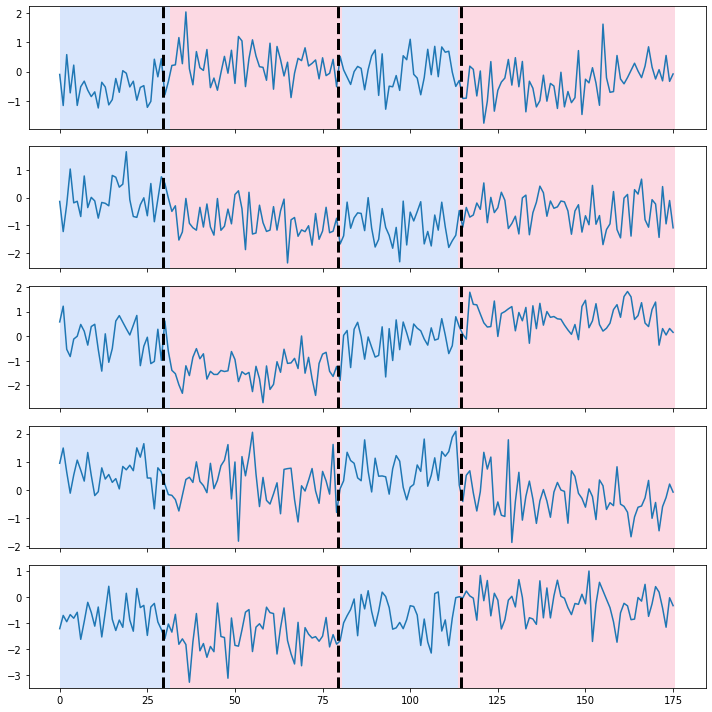

In [12]:
# Results using True PSD
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = VSGS(G, signal.T, PSD, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


4 changes points

            Hausdorff: 2.00, 
            Precision: 1.00, 
            Recall: 1.00, 
            Randindex: 0.98, 
            Hamming: 0.02
        


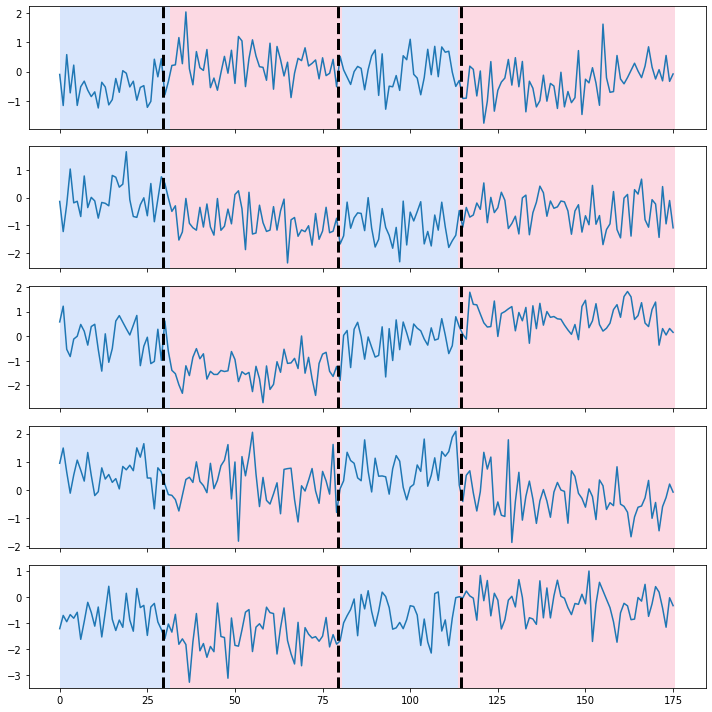

In [13]:
# Results using PSD estimation through covariance estimation
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = VSGS(G, signal.T, psd_covariance, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


4 changes points

            Hausdorff: 2.00, 
            Precision: 1.00, 
            Recall: 1.00, 
            Randindex: 0.98, 
            Hamming: 0.02
        


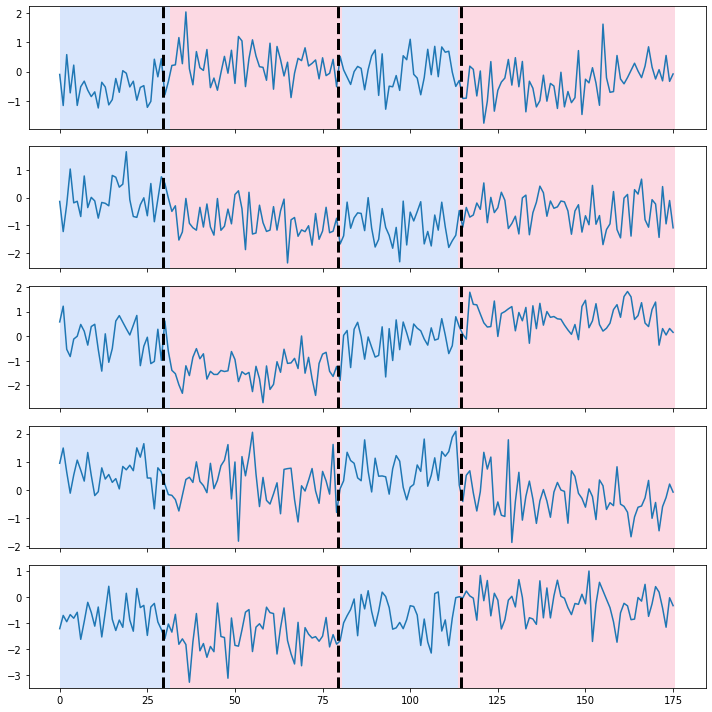

In [14]:
# Results using PSD estimation with perraudin methods
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = VSGS(G, signal.T, psd_perraudin, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

# Kernel methods

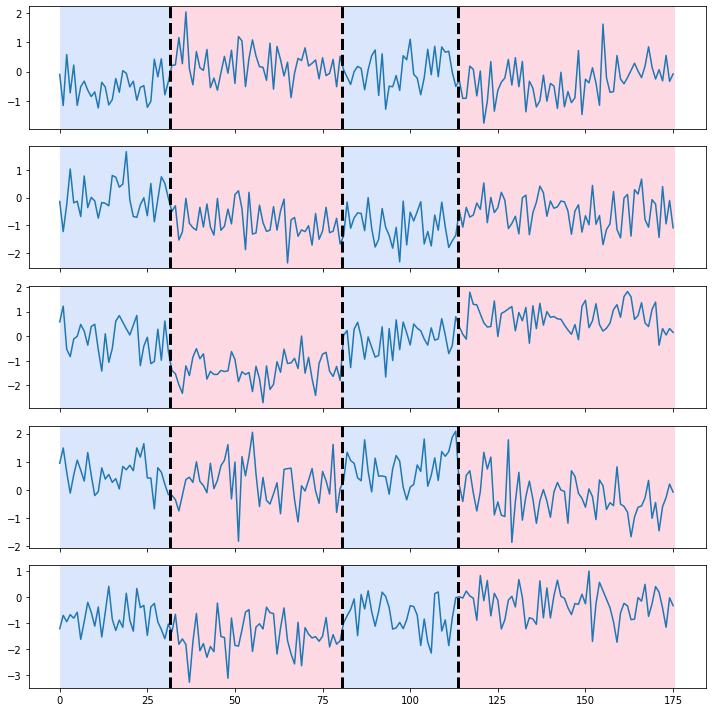

In [15]:
def Kernel(signal):
    # Slope heuristics to estimate penalty
    T, d = signal.shape
    k_min, k_max = 10, min(int(0.4*T), T//6)
    X = np.arange(k_min,k_max+1)
    y = []
    algo = rpt.Dynp(model="l2").fit(signal)
    cost = rpt.costs.CostL2().fit(signal)
    for k in range(k_min,k_max+1):
        curr_bkps = algo.predict(n_bkps=k)
        y.append(cost.sum_of_costs(curr_bkps))
    slope = LinearRegression().fit(np.expand_dims(X,-1), y).coef_[0]
    pen = - 2 * slope
    
    # Apply kernel change point detection
    algo = rpt.KernelCPD(kernel="linear").fit(signal)
    bkps = algo.predict(pen=pen)
    return bkps
    
# bkps = Kernel(signal.T @ G.U)
bkps = Kernel(signal.T)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

# Benchmark

In [16]:
def benchmark(method='VSGS', dataset='ER', PSD_type='true', n=100):
    """
    Compute mean performance of given setups over n runs
    
    Parameters
    ----------
    method: 'VSGS', 'LGS', 'Kernel'
    dataset: 'ER', 'BA'
    PSD_type: 'true', 'cov', 'perraudin'
    """
    metric_history = {
        'precision': [],
        'recall': [],
        'hausdorff': [],
        'randindex': []
    }
    for _ in tqdm(range(n)):
        # Generate Graph
        n_nodes = 500
        if dataset == 'BA':
            G, PSD, true_bkps, mus, signal = generate_barabasi_albert(n_nodes)
        elif dataset == 'ER':   
            G, PSD, true_bkps, mus, signal = generate_erdos_renyi(n_nodes)

        # Get PSD
        w = 40
        if PSD_type == 'cov':
            PSD = estimate_PSD_cov(signal[:,:w], G)
        elif PSD_type == 'perraudin':
            PSD = estimate_PSD_perraudin(signal[:,:w], G)

        # Apply algorithm
        T = signal.shape[1]
        d_max = min(int(T/np.log(T)), T//6)
        if method == 'LGS':
            bkps = LGS(G, signal.T, PSD, d_max=d_max, lbd=0.5, verbose=False)
            p, r, hausdorff, randindex = metrics(true_bkps, bkps, verbose=False)
        elif method == 'VSGS':
            lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
            bkps = VSGS(G, signal.T, PSD, lambda_set, d_max=d_max, verbose=False)
            p, r, hausdorff, randindex = metrics(true_bkps, bkps, verbose=False)
        elif method == 'Kernel':
            bkps = Kernel(signal.T)
            p, r, hausdorff, randindex = metrics(true_bkps, bkps, verbose=False)
            
        # Record metrics
        metric_history['precision'].append(p)
        metric_history['recall'].append(r)
        metric_history['hausdorff'].append(hausdorff)
        metric_history['randindex'].append(randindex)
    return metric_history

def analyse_benchmark(metric_history):
    for k,v in metric_history.items():
        data = np.array(v)
        print(f'{k:10}: mean {np.mean(v):.2f}, std {np.std(v):.3f}, median {np.median(v):.2f}')

In [17]:
# Graph methods benchmarks
parameters = {
    'method': ['LGS', 'VSGS'],
    'dataset': ['ER', 'BA'],
    'PSD_type': ['true', 'cov', 'perraudin']
}
for method in parameters['method']:
    for dataset in parameters['dataset']:
        for PSD_type in parameters['PSD_type']:
            print(f'method: {method}, dataset: {dataset}, PSD estimation: {PSD_type}')
            metric_history = benchmark(method=method, dataset=dataset, PSD_type=PSD_type, n=100)
            analyse_benchmark(metric_history)
            print(f'-----------------------')

method: LGS, dataset: ER, PSD estimation: true


100%|██████████| 100/100 [08:20<00:00,  5.00s/it]


precision : mean 1.00, std 0.020, median 1.00
recall    : mean 1.00, std 0.000, median 1.00
hausdorff : mean 1.72, std 0.531, median 2.00
randindex : mean 0.98, std 0.008, median 0.98
-----------------------
method: LGS, dataset: ER, PSD estimation: cov


100%|██████████| 100/100 [08:21<00:00,  5.01s/it]


precision : mean 0.98, std 0.052, median 1.00
recall    : mean 1.00, std 0.000, median 1.00
hausdorff : mean 1.91, std 0.549, median 2.00
randindex : mean 0.98, std 0.010, median 0.98
-----------------------
method: LGS, dataset: ER, PSD estimation: perraudin


100%|██████████| 100/100 [21:05<00:00, 12.66s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 1.00, std 0.000, median 1.00
hausdorff : mean 2.00, std 0.000, median 2.00
randindex : mean 0.98, std 0.001, median 0.98
-----------------------
method: LGS, dataset: BA, PSD estimation: true


100%|██████████| 100/100 [05:01<00:00,  3.02s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 0.96, std 0.104, median 1.00
hausdorff : mean 5.74, std 11.548, median 2.00
randindex : mean 0.97, std 0.036, median 0.98
-----------------------
method: LGS, dataset: BA, PSD estimation: cov


100%|██████████| 100/100 [05:00<00:00,  3.01s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 0.93, std 0.133, median 1.00
hausdorff : mean 8.52, std 13.834, median 2.00
randindex : mean 0.96, std 0.053, median 0.98
-----------------------
method: LGS, dataset: BA, PSD estimation: perraudin


100%|██████████| 100/100 [06:30<00:00,  3.91s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 0.67, std 0.033, median 0.67
hausdorff : mean 32.68, std 3.184, median 33.00
randindex : mean 0.88, std 0.010, median 0.88
-----------------------
method: VSGS, dataset: ER, PSD estimation: true


100%|██████████| 100/100 [13:15<00:00,  7.95s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 1.00, std 0.000, median 1.00
hausdorff : mean 1.71, std 0.516, median 2.00
randindex : mean 0.98, std 0.008, median 0.98
-----------------------
method: VSGS, dataset: ER, PSD estimation: cov


100%|██████████| 100/100 [14:41<00:00,  8.81s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 0.96, std 0.090, median 1.00
hausdorff : mean 8.87, std 15.157, median 2.00
randindex : mean 0.97, std 0.024, median 0.98
-----------------------
method: VSGS, dataset: ER, PSD estimation: perraudin


100%|██████████| 100/100 [23:49<00:00, 14.29s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 1.00, std 0.000, median 1.00
hausdorff : mean 2.00, std 0.000, median 2.00
randindex : mean 0.98, std 0.001, median 0.98
-----------------------
method: VSGS, dataset: BA, PSD estimation: true


100%|██████████| 100/100 [07:38<00:00,  4.59s/it]


precision : mean 1.00, std 0.033, median 1.00
recall    : mean 0.95, std 0.116, median 1.00
hausdorff : mean 6.96, std 13.184, median 2.00
randindex : mean 0.97, std 0.041, median 0.98
-----------------------
method: VSGS, dataset: BA, PSD estimation: cov


100%|██████████| 100/100 [07:26<00:00,  4.47s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 0.91, std 0.146, median 1.00
hausdorff : mean 10.95, std 15.971, median 2.00
randindex : mean 0.95, std 0.057, median 0.98
-----------------------
method: VSGS, dataset: BA, PSD estimation: perraudin


100%|██████████| 100/100 [08:01<00:00,  4.81s/it]

precision : mean 1.00, std 0.000, median 1.00
recall    : mean 0.67, std 0.033, median 0.67
hausdorff : mean 37.63, std 3.681, median 38.00
randindex : mean 0.87, std 0.011, median 0.87
-----------------------


In [18]:
# Kernel methods benchmarks
parameters = {
    'method': ['Kernel'],
    'dataset': ['ER', 'BA'],
}

for dataset in parameters['dataset']:
        print(f'method: linear kernel, dataset: {dataset}')
        metric_history = benchmark(method='Kernel', dataset=dataset, n=100)
        analyse_benchmark(metric_history)
        print(f'-----------------------')

method: linear kernel, dataset: ER


100%|██████████| 100/100 [07:58<00:00,  4.78s/it]


precision : mean 1.00, std 0.000, median 1.00
recall    : mean 1.00, std 0.000, median 1.00
hausdorff : mean 0.00, std 0.000, median 0.00
randindex : mean 1.00, std 0.000, median 1.00
-----------------------
method: linear kernel, dataset: BA


100%|██████████| 100/100 [04:46<00:00,  2.86s/it]

precision : mean 1.00, std 0.000, median 1.00
recall    : mean 0.98, std 0.079, median 1.00
hausdorff : mean 2.20, std 8.843, median 0.00
randindex : mean 0.99, std 0.028, median 1.00
-----------------------


# Application to real data

In [19]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
import geopandas
import contextily as cx

CRS = "EPSG:4326"

In [20]:
# Load data
data_df, stations_df, description = load_molene_meteo_dataset()

In [21]:
### Preprocessing of temperature dataframe

data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)

# Drop NaN values
temperature_df = temperature_df.dropna(axis=1)

print(f"The stations with missing values are {', '.join(sorted(list((set(data_df['station_name'])  - set(temperature_df.columns))))).title()}") 

temperature_df.head()

The stations with missing values are Arzal, Batz, Beg_Meil, Brest-Guipavas, Brignogan, Camaret, Landivisiau, Lannaero, Lanveoc, Ouessant-Stiff, Plouay-Sa, Ploudalmezeau, Plougonvelin, Quimper, Riec Sur Belon, Sizun, St Nazaire-Montoir, Vannes-Meucon


station_name,AURAY,BELLE ILE-LE TALUT,BIGNAN,DINARD,GUERANDE,GUISCRIFF SA,ILE DE GROIX,ILE-DE-BREHAT,KERPERT,LORIENT-LANN BIHOUE,...,SAINT-CAST-LE-G,SAINT-JOACHIM_SAE,SARZEAU SA,SIBIRIL S A,SPEZET,ST BRIEUC,ST-SEGAL S A,THEIX,TREGUNC,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,10.3,11.3,7.1,6.8,10.4,8.3,9.0,7.0,5.9,9.0,...,6.1,9.3,9.8,7.4,8.3,7.5,9.0,9.3,10.8,9.7
2014-01-01 01:00:00,10.4,10.3,7.6,6.5,10.6,7.8,10.0,7.0,5.9,10.0,...,6.3,9.3,9.9,8.2,8.6,7.0,9.5,9.1,10.9,9.9
2014-01-01 02:00:00,10.0,11.2,7.7,6.5,10.2,8.4,9.5,7.8,6.4,8.9,...,6.4,9.5,9.2,8.5,8.6,7.5,9.4,9.4,10.6,9.6
2014-01-01 03:00:00,10.4,11.4,7.9,7.1,10.6,8.4,10.4,8.3,6.7,10.1,...,7.0,9.0,10.1,8.5,8.9,7.2,9.9,8.9,10.8,9.8
2014-01-01 04:00:00,10.8,11.4,8.8,7.6,10.6,8.9,10.8,8.9,6.9,10.4,...,7.7,9.9,10.5,9.1,9.4,7.6,10.0,9.6,11.0,10.2


In [22]:
### Preprocessing of stations dataframe

stations_df_filtered = stations_df[stations_df['Nom'].isin(list(temperature_df.columns))]

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df_filtered,
    geometry=geopandas.points_from_xy(
        stations_df_filtered.Longitude, stations_df_filtered.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)
5,22168001,PLOUMANAC'H,48.825833,-3.473167,173516,2441036,55,POINT (-3.47317 48.82583)


In [23]:
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt
from pygsp import graphs

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [24]:
# Compute geodedic distances between all stations 
stations_np = stations_df_filtered[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance) # Distances computed in km

# Compute similarity using gaussian smoothing and median heuristic for bandwith parameter
bandwidth = np.median(dist_mat_condensed) # median heuristic
exp_similarity = np.exp( -(dist_mat_condensed ** 2) / np.square(bandwidth))

# Performs dichotomy to find the minimum threshold that keeps the graph connected with an average degree of at least 3
low = 0
high = 1
threshold = 1
eps = 1e-5
while np.abs(high - low) > eps:
    threshold = (high + low) / 2
    adjacency_matrix_gaussian = squareform(np.where(exp_similarity > threshold, exp_similarity, 0.0))
    G = graphs.Graph(adjacency_matrix_gaussian)
    is_connected = G.is_connected(recompute=True)
    if is_connected:
        low = threshold
    else:
        high = threshold

adjacency_matrix_gaussian = squareform(np.where(exp_similarity > low, exp_similarity, 0.0))
G = graphs.Graph(adjacency_matrix_gaussian)
is_connected = G.is_connected(recompute=True)

print(f"The minimum threshold so that the graph is connected is {low:.4f}.")
print(f"The average degree of the graph is {np.mean(G.d):.2f}.")
print(f"The average weighted degree of the graph is {np.mean(np.sum(adjacency_matrix_gaussian, axis=0)):.2f}")

The minimum threshold so that the graph is connected is 0.8324.
The average degree of the graph is 4.00.
The average weighted degree of the graph is 3.62


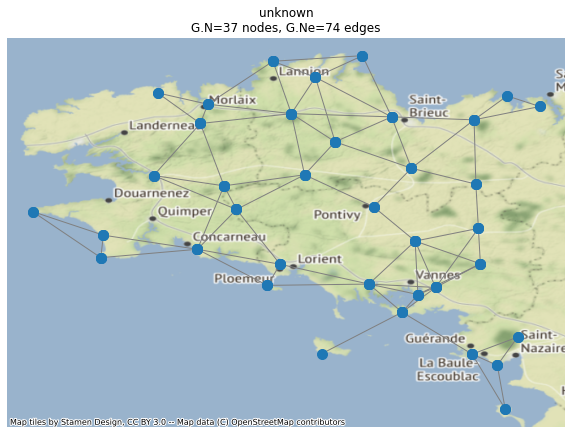

In [25]:
# Plot the graph
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

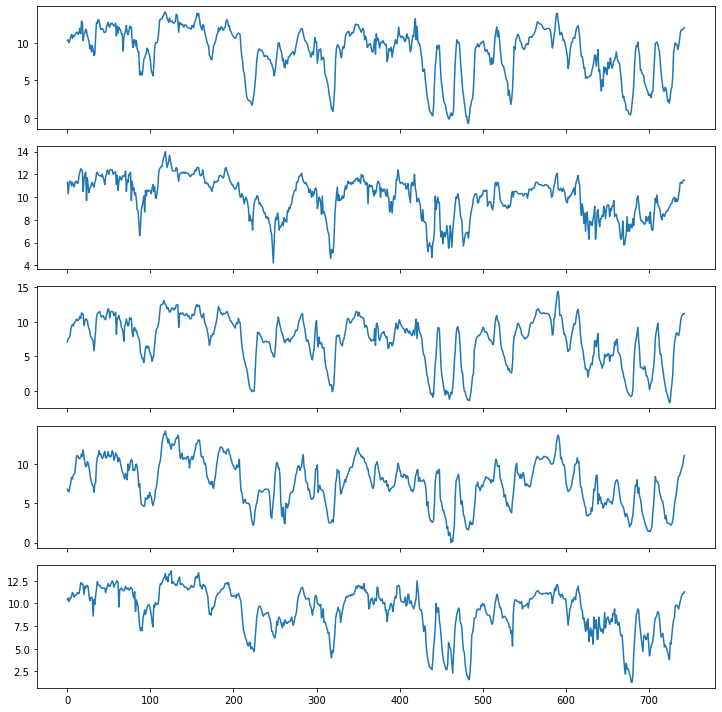

In [26]:
temperature_df_np = np.array(temperature_df)
rpt.display(temperature_df_np[:,:5], [])
plt.show()

2022-03-30 06:45:49,918:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


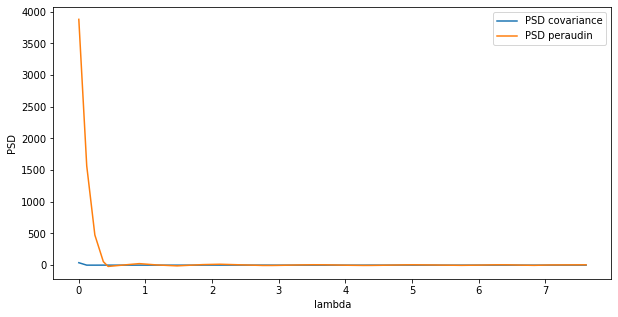

In [27]:
# Compute PSD
w = 80
psd_covariance_temp = estimate_PSD_cov(temperature_df_np[:w].T, G)
psd_perraudin_temp = estimate_PSD_perraudin(temperature_df_np[:w].T, G)

fig = plt.figure(figsize=(10, 5)) 
plt.plot(G.e, psd_covariance_temp, label="PSD covariance")
plt.plot(G.e, psd_perraudin_temp, label="PSD peraudin")
plt.xlabel("lambda")
plt.ylabel("PSD")
plt.legend()
plt.show()

## LGS

100%|██████████| 112/112 [00:03<00:00, 30.17it/s]


2 changes points


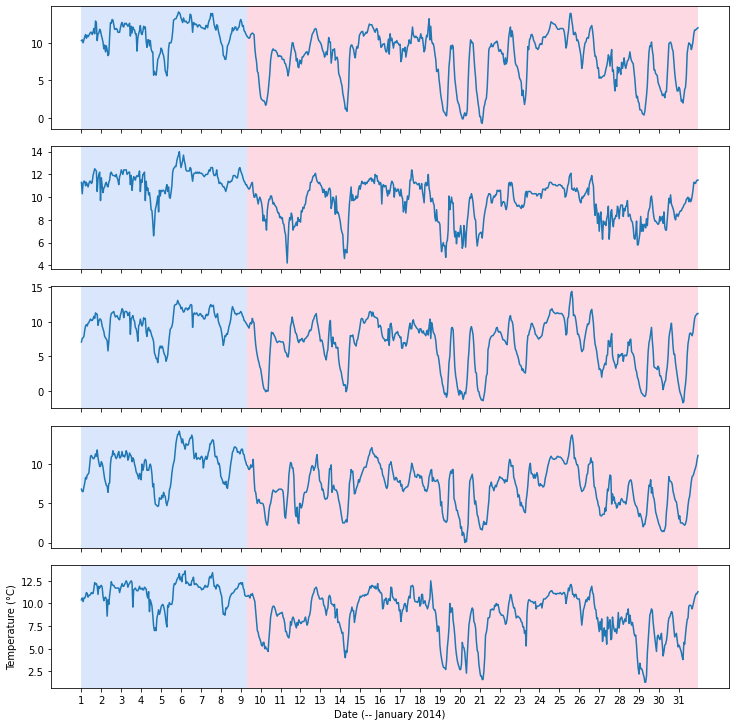

In [28]:
# Results Covariance PSD
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = LGS(G, temperature_df_np, psd_covariance_temp, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')

rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()

100%|██████████| 112/112 [00:03<00:00, 31.14it/s]


2 changes points


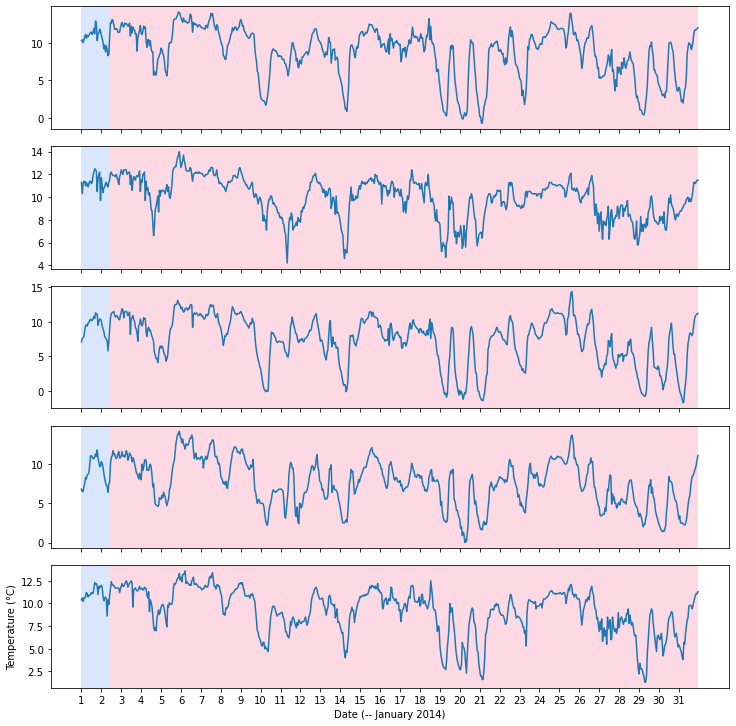

In [29]:
# Results Covariance PSD
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = LGS(G, temperature_df_np, psd_perraudin_temp, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')

rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()

## VSGS

100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


17 changes points


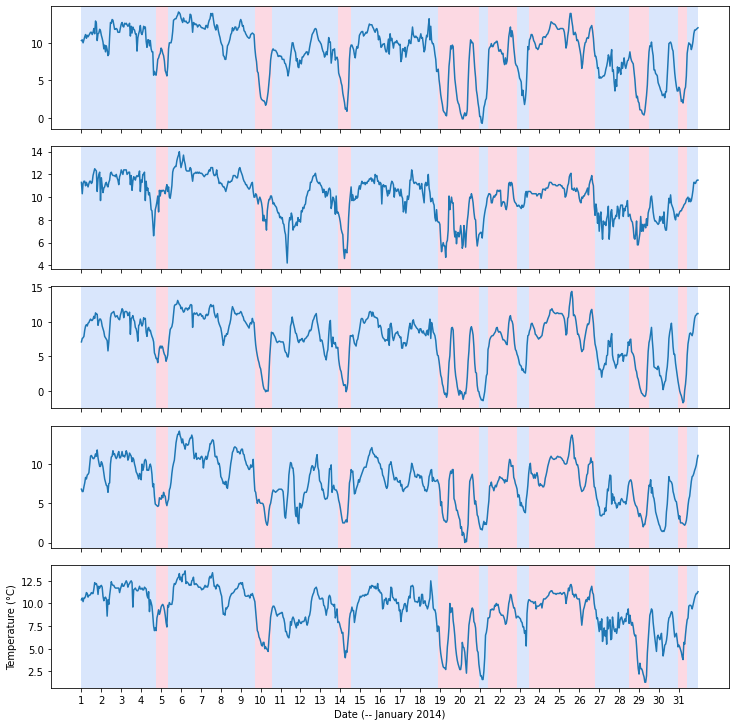

In [30]:
# Results using Covariance PSD
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = VSGS(G, temperature_df_np, psd_covariance_temp, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()

In [ ]:
bkps = [0] + bkps
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
maximum = 0
for i in range(len(bkps) -1):
    fourier = np.abs(G.gft(np.mean(temperature_df_np[bkps[i]:bkps[i+1]], axis=0)))
    maximum = max(maximum, np.max(fourier))
    ax.plot(fourier, label=f"{i}")

ax.plot([0, len(fourier)], [maximum * 0.01, maximum * 0.01], '--', c='black')
plt.yscale('log')
plt.xlabel('Composent number of the Fourier number')
plt.ylabel('Value of the Fourier coefficient')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Segment considered')

plt.show()

100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


15 changes points


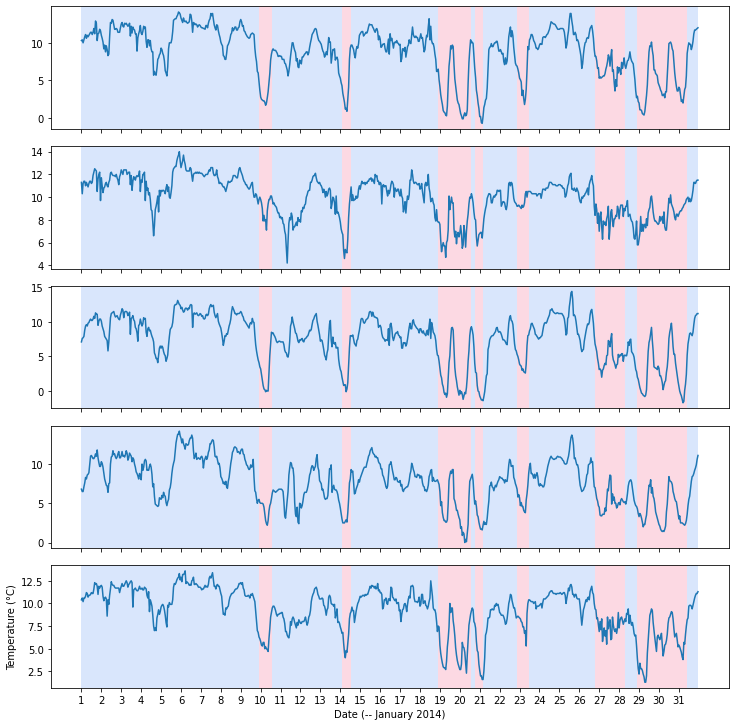

In [31]:
# Results using Peraudin PSD
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = VSGS(G, temperature_df_np, psd_perraudin_temp, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()

In [ ]:
bkps = [0] + bkps
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
maximum = 0
for i in range(len(bkps) -1):
    fourier = np.abs(G.gft(np.mean(temperature_df_np[bkps[i]:bkps[i+1]], axis=0)))
    maximum = max(maximum, np.max(fourier))
    ax.plot(fourier, label=f"{i}")

ax.plot([0, len(fourier)], [maximum * 0.01, maximum * 0.01], '--', c='black')
plt.yscale('log')
plt.xlabel('Composent number of the Fourier number')
plt.ylabel('Value of the Fourier coefficient')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Segment considered')

plt.show()